# 프로젝트: CutMix 또는 Mixup 비교실험 하기
|평가문항|	상세기준|
|:---|:---|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)
print(tfds.__version__)

2.6.0
1.21.4
4.4.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation을 적용한 데이터셋 만들기
데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.
- CutMix: 이미지를 잘라내서 섞는 방식
    - [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
    - [Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)
- Mixup: 특정 비율로 픽셀별 값을 섞는 방식
    - [mixup:Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

In [43]:
# stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 
# 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

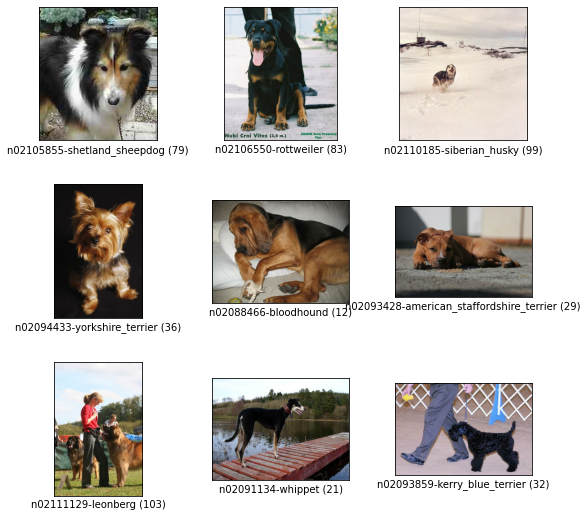

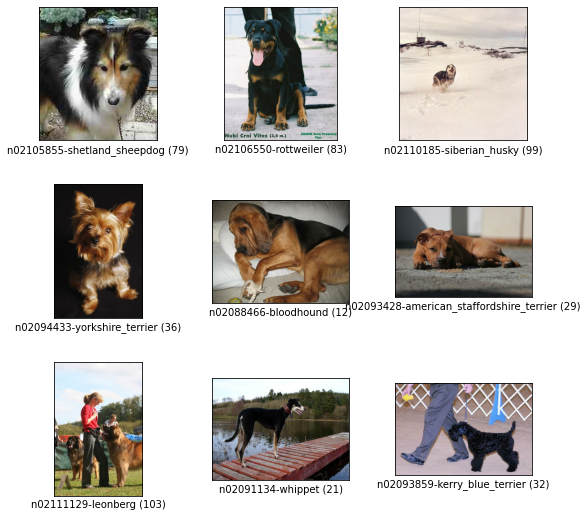

In [4]:
tfds.show_examples(ds_train, ds_info)

### (0) 기본적인 전처리 함수

In [44]:
# 이미지 데이터 기본 셋팅
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # (224, 224) 사이즈로 resize
    return tf.cast(image, tf.float32) / 255., label # 입력받은 이미지를 0~1 사이의 float32로 normalize

# 기본적인 augmentation 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 뒤집기
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 조절
    image = tf.clip_by_value(image, 0, 1) # 0~1 사이에 값만 통과
    return image, label

# one-hot encoding 함수
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### (1) CutMix augmentation

In [45]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1] # width
    image_size_y = image_a.shape[0] # height
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [46]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1] # width
    image_size_y = image_a.shape[0] # height
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [47]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [48]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### (2) Mixup augmentation

In [49]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [50]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### (3) 데이터셋에 적용

In [51]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 정규화 및 resize
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # train & basic augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size) # 우선 batch 적용 후 아래서 Cutmix/mixup
    
    
    # train & "special" augmentation
    if not is_test and with_cutmix: # train & cutmix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # train & mixup augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    # train인 경우 Shuffle
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 특성 추출기(feature extractor) 부분만 불러오기
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax') # 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 맞추기
])

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
# 기본 Augmentation을 위한 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
# cutmix Augmentation을 위한 모델
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
# mixup Augmentation을 위한 모델
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [52]:
# train
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

# test
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### aug방법별 샘플 확인
- image histogram
- visual inspection

In [96]:
ds_train_no_aug.take(1).shape

AttributeError: 'TakeDataset' object has no attribute 'shape'

In [91]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    print(image, label)
    #img = tf.keras.preprocessing.image.array_to_img(image)
    
#     plt.subplot(1,col+1,i+1)
#     plt.title(f'Center crop: {label}')
#     plt.imshow(img)

tf.Tensor(
[[[[4.84952748e-01 3.63384098e-01 1.39854684e-01]
   [4.88874316e-01 3.63384098e-01 1.39854684e-01]
   [4.88226533e-01 3.61790955e-01 1.37946442e-01]
   ...
   [5.47049999e-01 4.21559840e-01 1.35285333e-01]
   [5.44659674e-01 4.19169426e-01 1.32894933e-01]
   [5.40134549e-01 4.14644331e-01 1.28369823e-01]]

  [[4.78387594e-01 3.56818974e-01 1.33289561e-01]
   [4.86267865e-01 3.60777676e-01 1.37248263e-01]
   [4.91185248e-01 3.64749640e-01 1.40905112e-01]
   ...
   [5.53216040e-01 4.27725852e-01 1.41451329e-01]
   [5.36703348e-01 4.11213219e-01 1.24938697e-01]
   [5.31844497e-01 4.06354308e-01 1.20079778e-01]]

  [[4.74509805e-01 3.52941185e-01 1.29411772e-01]
   [4.85679269e-01 3.60189080e-01 1.36659667e-01]
   [4.95063037e-01 3.68627459e-01 1.44782916e-01]
   ...
   [5.49433887e-01 4.23943698e-01 1.37669191e-01]
   [5.37893832e-01 4.12403703e-01 1.26129165e-01]
   [5.32301545e-01 4.06811386e-01 1.20536849e-01]]

  ...

  [[4.35294122e-01 3.37254912e-01 1.25490203e-01]
   [4

## 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [31]:
EPOCH = 10 # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [32]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 155s 198ms/step - loss: 0.6646 - accuracy: 0.8213 - val_loss: 1.3144 - val_accuracy: 0.6302
Epoch 2/10
750/750 [==============================] - 150s 200ms/step - loss: 0.2475 - accuracy: 0.9474 - val_loss: 0.9750 - val_accuracy: 0.7171
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0715 - accuracy: 0.9921 - val_loss: 0.9248 - val_accuracy: 0.7301
Epoch 4/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0287 - accuracy: 0.9987 - val_loss: 0.9231 - val_accuracy: 0.7348
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0170 - accuracy: 0.9998 - val_loss: 0.9381 - val_accuracy: 0.7368
Epoch 6/10
750/750 [==============================] - 150s 199ms/step - loss: 0.0117 - accuracy: 0.9998 - val_loss: 0.9418 - val_accuracy: 0.7381
Epoch 7/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0103 - accuracy: 0.9996 - val_loss: 0.9556 -

In [34]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 157s 200ms/step - loss: 0.4117 - accuracy: 0.8968 - val_loss: 1.1506 - val_accuracy: 0.6735
Epoch 2/10
750/750 [==============================] - 150s 199ms/step - loss: 0.2231 - accuracy: 0.9489 - val_loss: 1.0504 - val_accuracy: 0.7013
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 0.1201 - accuracy: 0.9775 - val_loss: 0.8964 - val_accuracy: 0.7421
Epoch 4/10
750/750 [==============================] - 150s 199ms/step - loss: 0.0703 - accuracy: 0.9902 - val_loss: 0.8849 - val_accuracy: 0.7522
Epoch 5/10
750/750 [==============================] - 150s 199ms/step - loss: 0.0426 - accuracy: 0.9945 - val_loss: 0.8977 - val_accuracy: 0.7502
Epoch 6/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0280 - accuracy: 0.9980 - val_loss: 0.9053 - val_accuracy: 0.7551
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0226 - accuracy: 0.9977 - val_loss: 0.8996 -

In [53]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # 기본+cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 201ms/step - loss: 2.8471 - accuracy: 0.4656 - val_loss: 1.3335 - val_accuracy: 0.6301
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 2.6347 - accuracy: 0.5328 - val_loss: 1.2070 - val_accuracy: 0.6628
Epoch 3/10
750/750 [==============================] - 151s 201ms/step - loss: 2.4888 - accuracy: 0.5792 - val_loss: 1.1266 - val_accuracy: 0.6814
Epoch 4/10
750/750 [==============================] - 151s 201ms/step - loss: 2.3756 - accuracy: 0.6155 - val_loss: 1.1868 - val_accuracy: 0.6820
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 2.2710 - accuracy: 0.6463 - val_loss: 1.1770 - val_accuracy: 0.6729
Epoch 6/10
750/750 [==============================] - 151s 201ms/step - loss: 2.1794 - accuracy: 0.6704 - val_loss: 1.1630 - val_accuracy: 0.6827
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 2.1186 - accuracy: 0.6922 - val_loss: 1.2418 -

In [54]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # 기본+cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 202ms/step - loss: 3.7528 - accuracy: 0.2262 - val_loss: 3.9385 - val_accuracy: 0.1213
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 2.9222 - accuracy: 0.4618 - val_loss: 1.8939 - val_accuracy: 0.4906
Epoch 3/10
750/750 [==============================] - 151s 201ms/step - loss: 2.6690 - accuracy: 0.5468 - val_loss: 1.3700 - val_accuracy: 0.6163
Epoch 4/10
750/750 [==============================] - 151s 201ms/step - loss: 2.5129 - accuracy: 0.6048 - val_loss: 1.3586 - val_accuracy: 0.6259
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 2.4081 - accuracy: 0.6470 - val_loss: 1.4541 - val_accuracy: 0.6088
Epoch 6/10
750/750 [==============================] - 151s 201ms/step - loss: 2.2845 - accuracy: 0.6858 - val_loss: 1.3627 - val_accuracy: 0.6350
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 2.2232 - accuracy: 0.7160 - val_loss: 1.1930 -

## 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

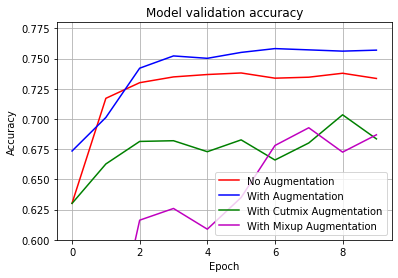

In [68]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='lower right')
plt.grid(True)
#plt.ylim(0, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
plt.ylim(0.60, 0.78)  # 자세히 보기
plt.show()

## 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [74]:
print("Accuracy 비교")
print("no augmentation:",history_resnet50.history['val_accuracy'][-1])
print("기본 augmentation:",history_resnet50_aug.history['val_accuracy'][-1])
print("기본 + Cutmix augmentation:",history_resnet50_cutmix.history['val_accuracy'][-1])
print("기본 + Mixup augmentation:",history_resnet50_mixup.history['val_accuracy'][-1])

Accuracy 비교
no augmentation: 0.7335587739944458
기본 augmentation: 0.7569962739944458
기본 + Cutmix augmentation: 0.6835354566574097
기본 + Mixup augmentation: 0.6869170069694519


Validation accuracy 기준 모델 성능 비교: `기본 aug > no aug > 기본+mixup > 기본+cutmix`

## (추가) epoch 20으로 학습

In [76]:
EPOCH_add = 10 # 기존 10에서 추가(additional) 에포크 10

In [77]:
history_resnet50_add = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_add, # epoch 10번 추가 
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 153s 199ms/step - loss: 0.0367 - accuracy: 0.9947 - val_loss: 1.0782 - val_accuracy: 0.7084
Epoch 2/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.9816 - val_accuracy: 0.7366
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0060 - accuracy: 0.9995 - val_loss: 0.9788 - val_accuracy: 0.7375
Epoch 4/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0044 - accuracy: 0.9999 - val_loss: 0.9966 - val_accuracy: 0.7374
Epoch 5/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0037 - accuracy: 0.9999 - val_loss: 0.9934 - val_accuracy: 0.7379
Epoch 6/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.9994 - val_accuracy: 0.7366
Epoch 7/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.0077 -

In [78]:
history_resnet50_aug_add = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_add, # epoch 10번 추가 
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 153s 199ms/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.9823 - val_accuracy: 0.7415
Epoch 2/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0239 - accuracy: 0.9977 - val_loss: 0.9644 - val_accuracy: 0.7490
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0093 - accuracy: 0.9994 - val_loss: 0.9262 - val_accuracy: 0.7625
Epoch 4/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0080 - accuracy: 0.9993 - val_loss: 0.9315 - val_accuracy: 0.7613
Epoch 5/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0055 - accuracy: 0.9998 - val_loss: 0.9313 - val_accuracy: 0.7611
Epoch 6/10
750/750 [==============================] - 165s 221ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 0.9490 - val_accuracy: 0.7628
Epoch 7/10
750/750 [==============================] - 150s 200ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.9859 -

In [79]:
history_resnet50_cutmix_add = cutmix_resnet50.fit(
    ds_train_cutmix, # 기본+cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_add, # epoch 10번 추가 
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 208ms/step - loss: 1.9276 - accuracy: 0.7446 - val_loss: 1.1663 - val_accuracy: 0.6936
Epoch 2/10
750/750 [==============================] - 151s 202ms/step - loss: 1.8658 - accuracy: 0.7556 - val_loss: 1.3171 - val_accuracy: 0.6646
Epoch 3/10
750/750 [==============================] - 152s 202ms/step - loss: 1.8626 - accuracy: 0.7589 - val_loss: 1.3656 - val_accuracy: 0.6540
Epoch 4/10
750/750 [==============================] - 151s 202ms/step - loss: 1.8058 - accuracy: 0.7787 - val_loss: 1.2462 - val_accuracy: 0.6834
Epoch 5/10
750/750 [==============================] - 151s 202ms/step - loss: 1.7779 - accuracy: 0.7833 - val_loss: 1.2658 - val_accuracy: 0.6844
Epoch 6/10
750/750 [==============================] - 167s 222ms/step - loss: 1.7321 - accuracy: 0.7915 - val_loss: 1.2182 - val_accuracy: 0.6933
Epoch 7/10
750/750 [==============================] - 151s 202ms/step - loss: 1.7214 - accuracy: 0.7909 - val_loss: 1.2348 -

In [80]:
history_resnet50_mixup_add = mixup_resnet50.fit(
    ds_train_mixup, # 기본+cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_add, # epoch 10번 추가 
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 165s 214ms/step - loss: 2.0239 - accuracy: 0.7861 - val_loss: 1.3450 - val_accuracy: 0.6400
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 1.9637 - accuracy: 0.8043

KeyboardInterrupt: 

In [85]:
# 기존 10 에포크 history와 추가적인 10 에포크 history 합치기
new_history_no_aug = history_resnet50.history['val_accuracy']+history_resnet50_add.history['val_accuracy']
new_history_aug = history_resnet50_aug.history['val_accuracy']+history_resnet50_aug_add.history['val_accuracy']
new_history_cutmix = history_resnet50_cutmix.history['val_accuracy']+history_resnet50_cutmix_add.history['val_accuracy']
#new_history_mixup = history_resnet50_mixup.history['val_accuracy']+history_resnet50_mixup_add.history['val_accuracy']

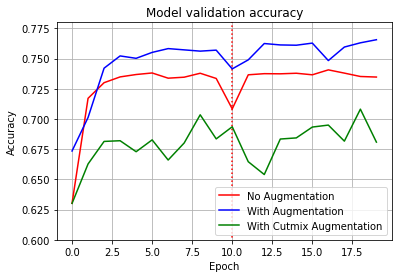

In [97]:
# 그래프 시각화
plt.plot(new_history_no_aug, 'r')
plt.plot(new_history_aug, 'b')
plt.plot(new_history_cutmix, 'g')
#plt.plot(new_history_mixup, 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='lower right')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix Augmentation'], loc='lower right')
plt.grid(True)
plt.vlines(x=10, ymin=0, ymax=1, color='red', linestyle='dotted') # epoch 10 기준선
#plt.ylim(0, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
plt.ylim(0.60, 0.78)  # 자세히 보기
plt.show()

In [88]:
print("Accuracy 비교(epoch 10)")
print("no augmentation:",history_resnet50.history['val_accuracy'][-1])
print("기본 augmentation:",history_resnet50_aug.history['val_accuracy'][-1])
print("기본 + Cutmix augmentation:",history_resnet50_cutmix.history['val_accuracy'][-1])
print("기본 + Mixup augmentation:",history_resnet50_mixup.history['val_accuracy'][-1])

print("Accuracy 비교(epoch 20)")
print("no augmentation:", new_history_no_aug[-1])
print("기본 augmentation:", new_history_aug[-1])
print("기본 + Cutmix augmentation:", new_history_cutmix[-1])
#print("기본 + Mixup augmentation:",history_resnet50_mixup.history['val_accuracy'][-1])

Accuracy 비교(epoch 10)
no augmentation: 0.7335587739944458
기본 augmentation: 0.7569962739944458
기본 + Cutmix augmentation: 0.6835354566574097
기본 + Mixup augmentation: 0.6869170069694519
Accuracy 비교(epoch 20)
no augmentation: 0.7347248196601868
기본 augmentation: 0.765625
기본 + Cutmix augmentation: 0.680853545665741


epoch을 10번 추가했음에도 불구하고 모든 모델에서 성능이 크게 달라지지 않았다.

# 회고
- epoch 20짜리 "기본 + Mixup augmentation" 모델이 학습 중 멈췄다. 메모리 문제로 추정
- Dataset 객체에 대한 이해가 더욱 필요하다.
- epoch을 10번 먼저 하고나서 그대로 이어서 fit해봤다. 혹은 민규님 방식처럼 epocha마다 모델결과를 로컬에 디렉토리에 저장할 수도 있다.
- 모델 규모나 데이터 사이즈에 따라서 컴퓨터 메모리 부족으로 커널이 죽는 경우가 있으니 주의해야 한다.